In [1]:
import matplotlib.pyplot as plt
from kraken.spot.client import Market
import pandas as pd

___
# Load historical XBT/USD 4h ohlc data for the past month

In [10]:
df = pd.DataFrame(
    Market().get_ohlc(pair='XBTUSD', interval=240, since=1653934926)['XXBTZUSD'], # 4h candles since August 2th 2022 until November 30. 2022
    columns=['time', 'open', 'high', 'low', 'close', 'vwap', 'volume', 'count']
).astype(float)
df['time'] = pd.to_datetime(df['time'], unit='s')
df = df.set_index('time')
df = df.sort_values(by='time')
df

,open,high,low,close,vwap,volume,count
time,,,,,,,
2022-08-02 20:00:00,22954.8,23149.5,22925.0,22994.0,23016.1,317.922939,2929.0
2022-08-03 00:00:00,22994.0,23065.9,22700.0,22870.0,22823.2,270.141207,3224.0
2022-08-03 04:00:00,22862.0,23065.0,22810.8,22988.7,23000.8,238.197559,1970.0
2022-08-03 08:00:00,22991.4,23469.3,22991.4,23400.0,23335.5,439.240653,3224.0
2022-08-03 12:00:00,23400.0,23650.0,23218.4,23362.0,23359.9,1425.167180,5559.0
...,...,...,...,...,...,...,...
2022-11-30 00:00:00,16428.8,17083.2,16420.2,16845.1,16816.8,1310.687297,8353.0
2022-11-30 04:00:00,16845.8,16917.6,16820.5,16883.6,16871.7,256.366609,3073.0
2022-11-30 08:00:00,16882.7,16924.9,16845.1,16881.6,16882.3,195.279083,2307.0


Text(0, 0.5, 'price in Dollar')

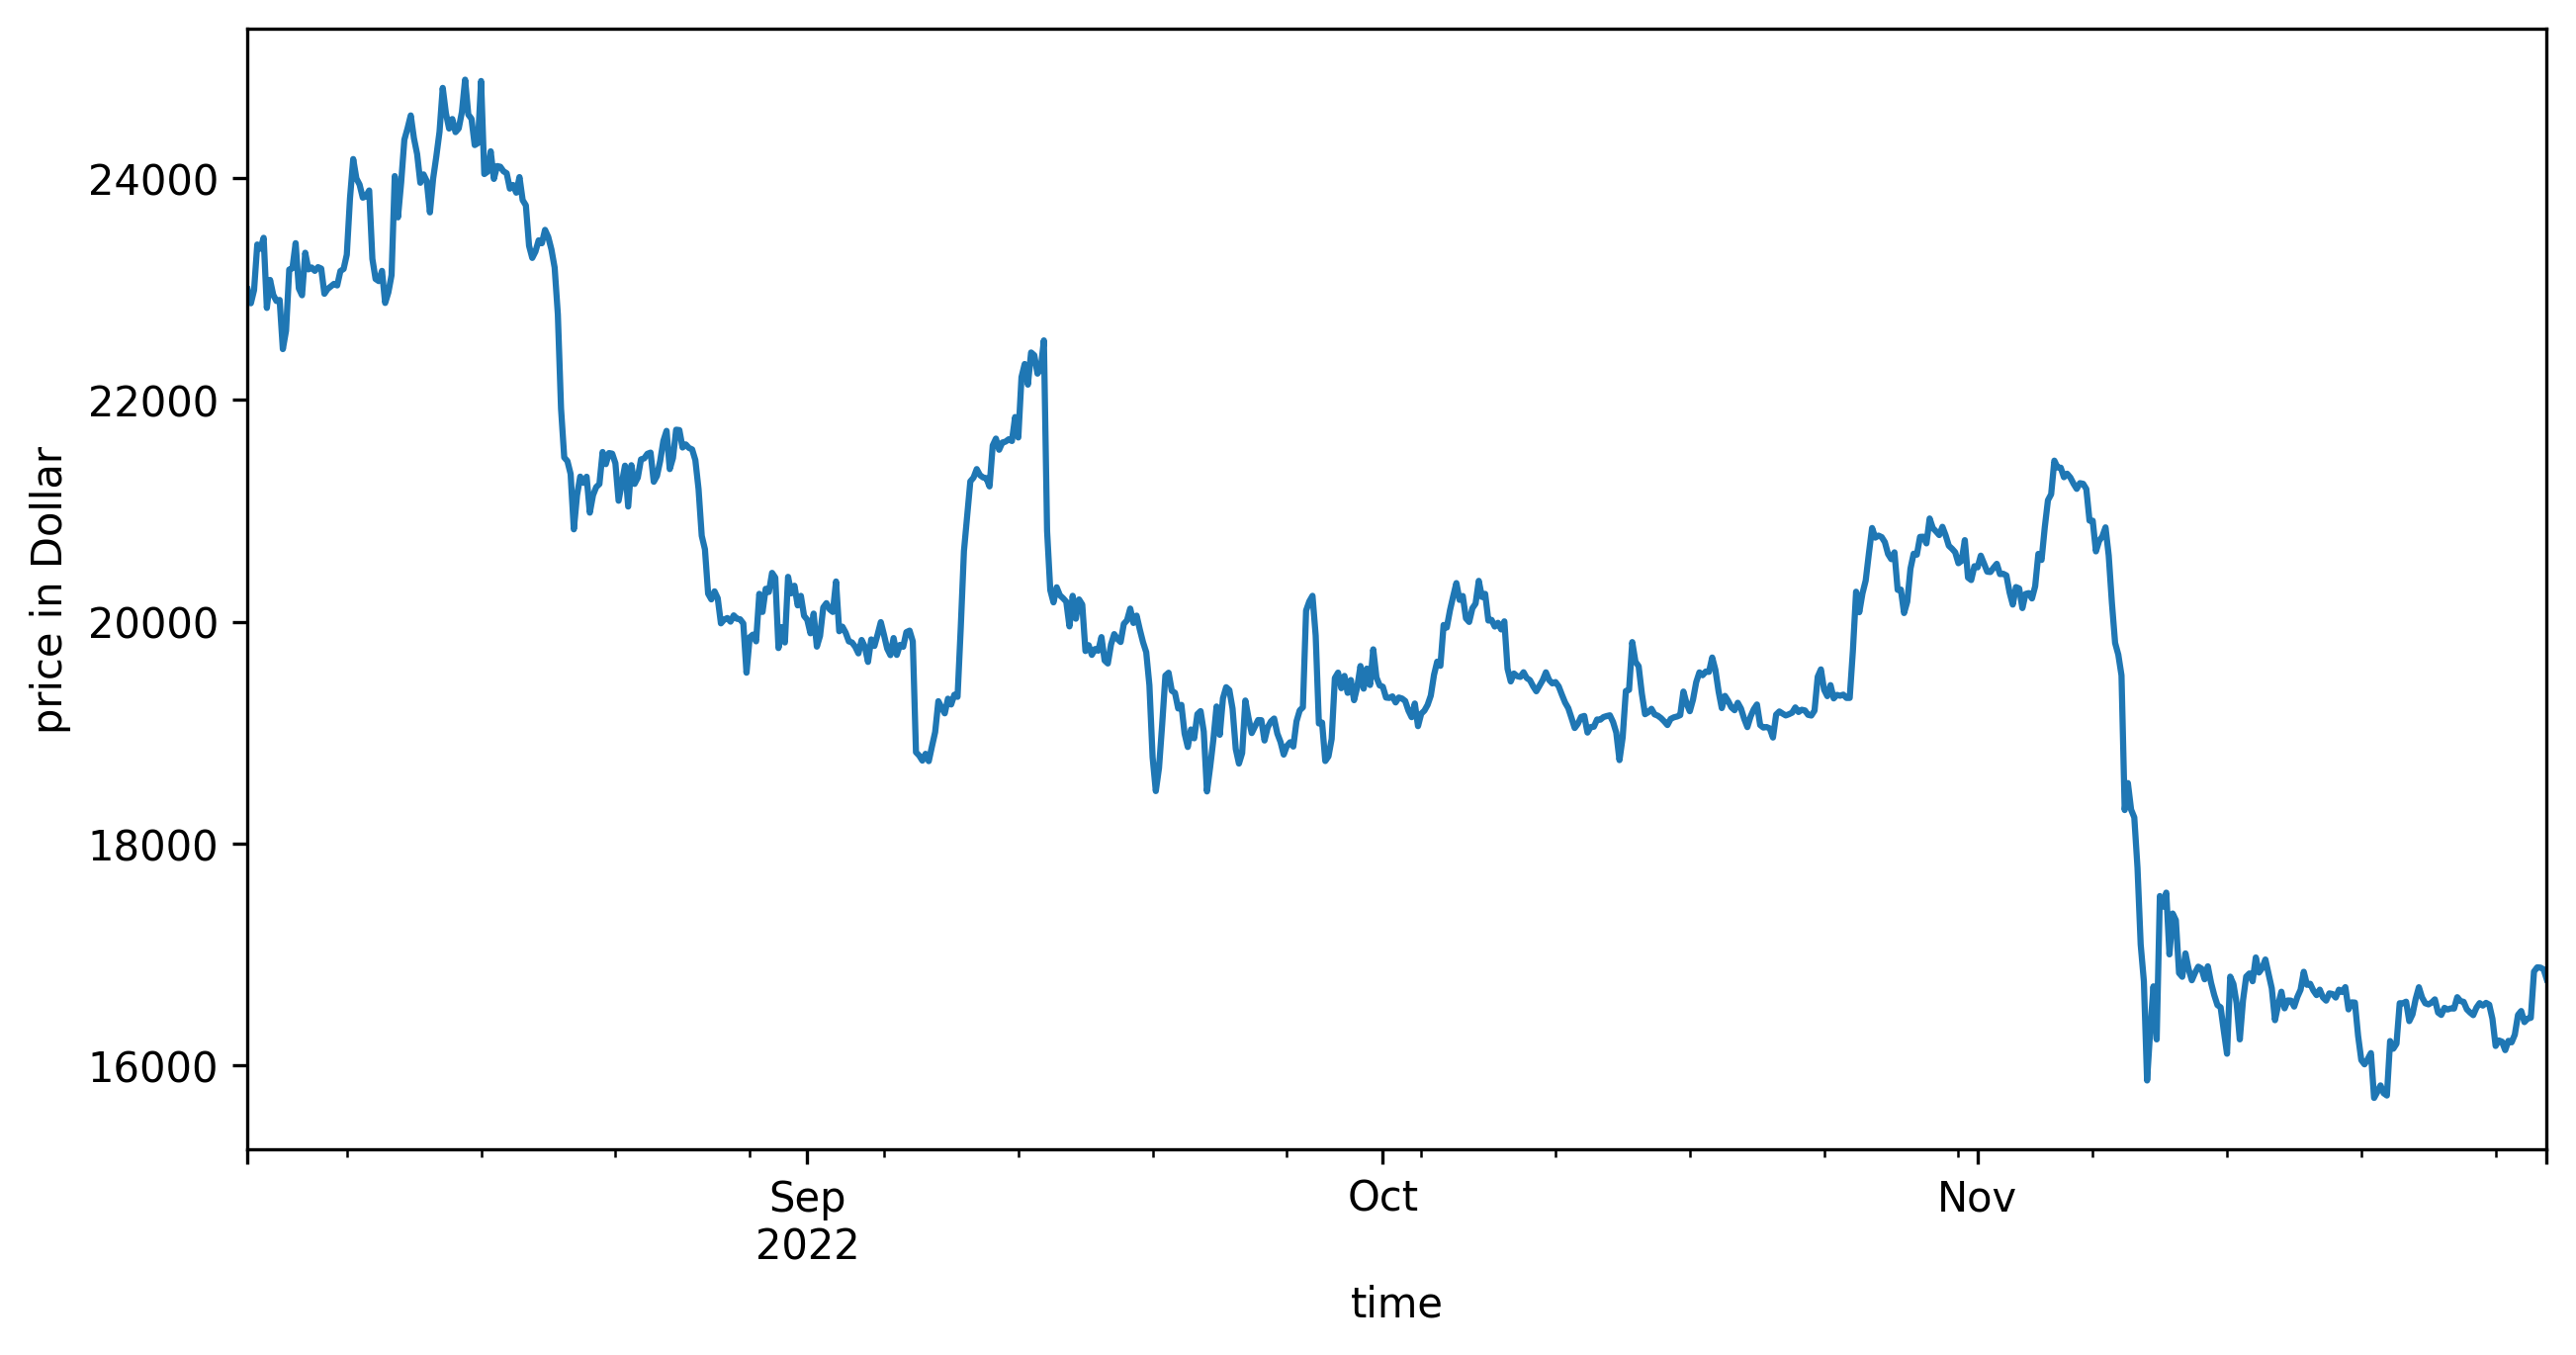

In [11]:
plt.figure(figsize=(10,5), dpi=300)
ax = plt.gca()
df.close.plot(ax=ax)
ax.set_ylabel('price in Dollar')

____
# Test the strategy based on this data

In [13]:
margin = 0.04           # set 4% margin
initial_quote = 200     # how many USD is in your portfolio at the beginning
quotes = initial_quote  # available quote currency
target = 100            # how much value of BTC to hold ($100 worth of BTC)
initial_holdings = 0    # how many BTC is in your portfolio at the beginniing
holdings = initial_holdings
fee = 0.0026            # taker fee without any Tier level
payed_fee = 0
n_trades = 0

for price in df.close:
    actual_value = holdings * price
    if actual_value < target - target * margin:
        to_buy = target - actual_value
        xfee = to_buy * fee
        quotes -= to_buy + xfee
        holdings += (to_buy - xfee) / price
        payed_fee += xfee
        n_trades += 1
    if actual_value > target + target * margin:
        to_sell = abs(target - actual_value)
        xfee = to_sell * fee
        quotes += to_sell - xfee
        holdings -= to_sell / price
        payed_fee += xfee
        n_trades += 1

profit = (quotes + holdings * df.close.iloc[-1]) - (initial_quote)
pprofit = (1 - (quotes + holdings * df.close.iloc[-1]) / (initial_quote)) * -100

print(f'Available USD: {quotes}                                         \
    \nAvailable BTC: {holdings} ~ {holdings * df.close.iloc[-1]} USD    \
    \nPayed fee: {payed_fee} USD                                        \
    \nNumber of trades: {n_trades}                                      \
    \nProfits: {profit} USD ({round(pprofit,2)}%)                       \
    \nPortfolio net worth: {quotes + holdings * df.close.iloc[-1]} USD ({round(pprofit,2)}%)' 
)

Available USD: 71.39247657299798                                             
Available BTC: 0.005986446684705825 ~ 100.42324178060868 USD        
Payed fee: 0.6966168993175564 USD                                            
Number of trades: 34                                          
Profits: -28.184281646393345 USD (-14.09%)                           
Portfolio net worth: 171.81571835360666 USD (-14.09%)


As you can see, the bot is not profitable in this bear market. But maybe better than going all in at a high price or using DCA based on time intervals at random prices.

This strategy might be profitable when the market is in a range or a different asset is used. 